In [1]:
import rasterio
import matplotlib 
import matplotlib.pyplot as plt
import os
import numpy as np
import re
from matplotlib import gridspec
from numpy import newaxis
import matplotlib.image as mpimg
import glob

matplotlib.rc('text', usetex = False)

In [3]:
class classes:
    classes_MCD12Q1v6LCProp2 = ['NoData',
        'Barren',
        'Water Bodies',
        'Urban and Built-up Lands',
        'Dense Forests',
        'Open Forests',
        'Natural Herbaceous',
        'Herbaceous Croplands',
        'Shrublands' ]

    short_MCD12Q1v6LCProp2 = ['NoData','Ba', 
                                 'W', 'Bu','DF', 
                              'OF', 'NH', 
                                'HC','S']
        
    colors_MCD12Q1v6LCProp2 = [ '#ababab', '#f9ffa4', 
                               '#1c0dff','#fa0000', '#003f00', 
                               '#006c00', '#b6ff05', 
                               '#f096ff', '#dcd159' ]

In [4]:
dataset_config = {
        'MCD12Q1v6stable01to15_LCProp2_major': {
            'classes': classes.classes_MCD12Q1v6LCProp2,
            'shortname': classes.short_MCD12Q1v6LCProp2,
            'colors': classes.colors_MCD12Q1v6LCProp2, 
            'name': 'M8*'}
    }

In [5]:
def read_file(file):
    with rasterio.open(file) as src:
        return (src.read(1))

In [6]:
def plot_year(post_files, colormap, vmin, vmax, title):
    gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.05, hspace=0.2)

    fig, axes = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(20, 10), gridspec_kw=gridspec_kwargs)

    axs = axes.flatten()

    for i, data in enumerate(post_files):
        axs[i].imshow(data, cmap=colormap, interpolation='none', vmin=vmin, vmax=vmax) 
        axs[i].axis('off')
        
    fig.text(0.45, 0.5, title, fontsize='xx-large', weight='bold', ha='center', va='center', rotation='vertical')

    plt.tight_layout()   

In [7]:
tiles = ['tl_bogota','tl_africa','tl_asia']
datasets = ['MCD12Q1v6stable01to15_LCProp2_major']
bms = [2, 0, 1]
models = ['Scratch', 'Pretrained \n without retraining','Pretrained \n with retraining']
tyear = 2003
rootdir = r'F:\acoca\research\gee\dataset'
tiles_name = ['Bogota, COL \nSouth America','Lisala, DRC \nAfrica', 'Pontianak, IDN \nAsia']

MCD12Q1v6stable01to15_LCProp2_major


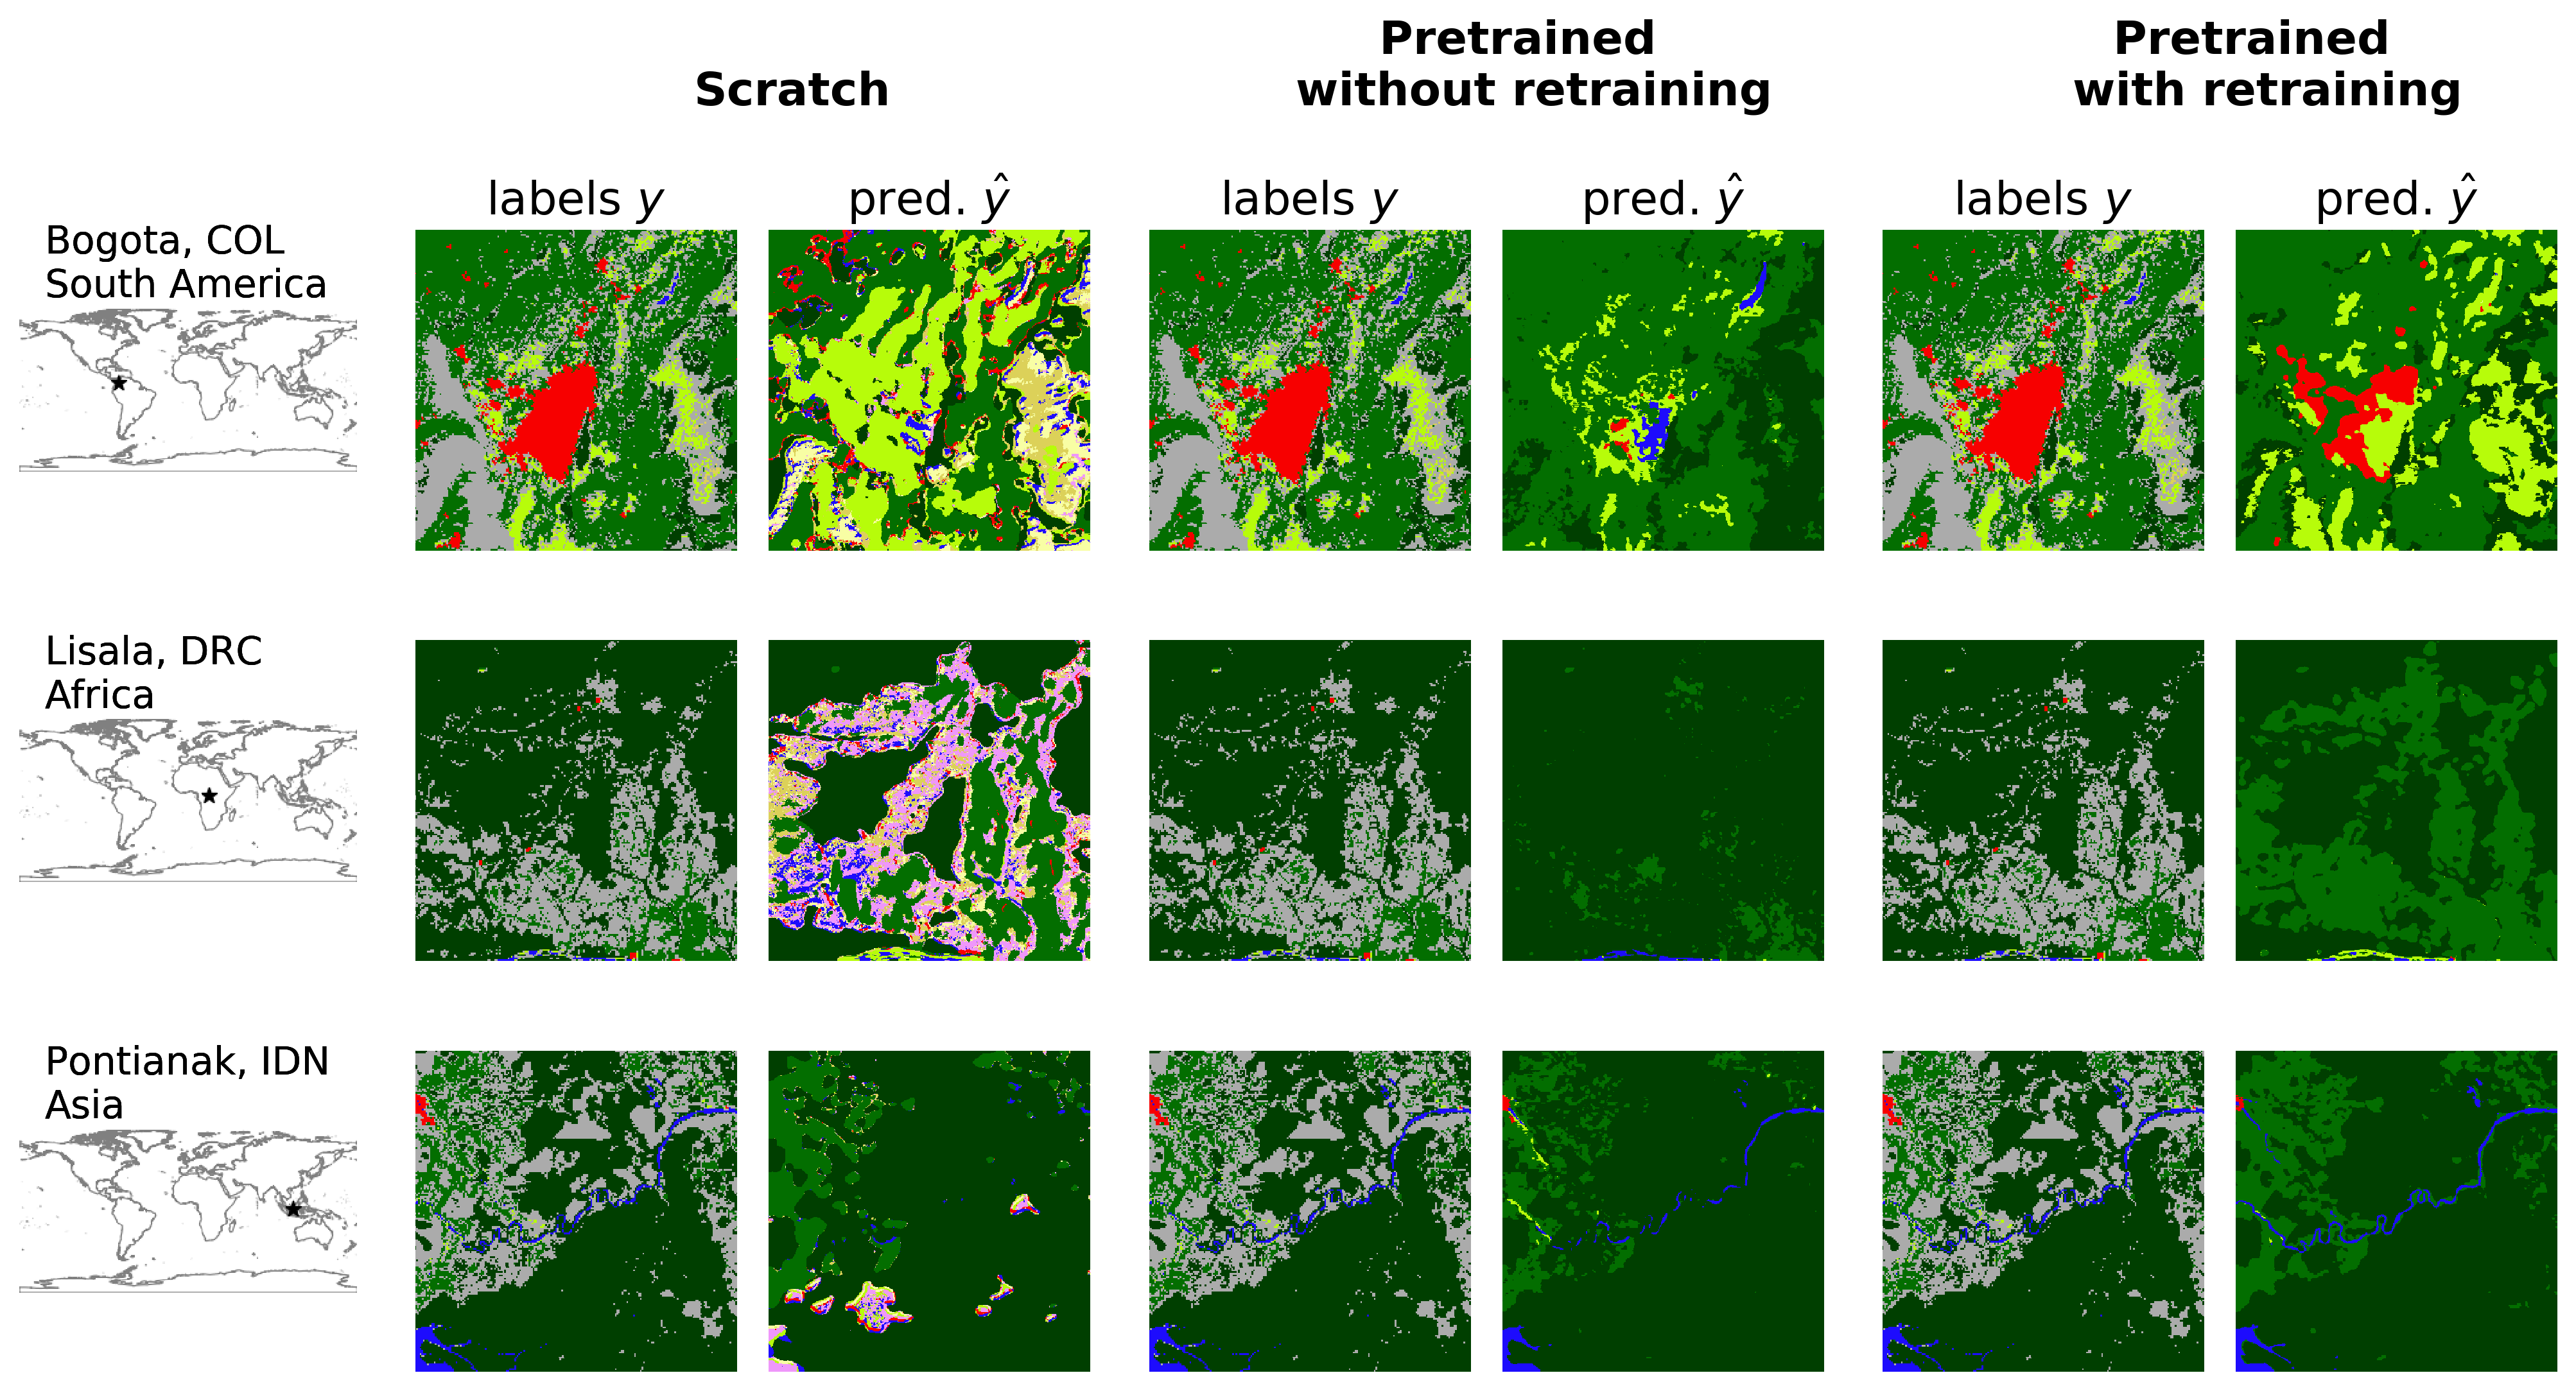

In [12]:
gs0 = gridspec.GridSpec(1, 4,  wspace=0.1, width_ratios = [0.5, 1, 1, 1])
fig = plt.figure(figsize=(17, 8), constrained_layout=False, dpi=300)

for d in datasets:
    for x, m in enumerate(models):
        gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, wspace=0.1, subplot_spec=gs0[0])
        gs01 = gridspec.GridSpecFromSubplotSpec(3, 2, wspace=0.1, subplot_spec=gs0[x+1])

        ver_list = [glob.glob(os.path.join(rootdir,'{}/eval/verification/{}/{}/{}'.format(t,d,tyear,d) ,'*.tif')) for t in tiles]
        id_list = [os.path.basename(t[0]).split('_')[1] for t in ver_list]

        pred_list = [os.path.join(rootdir,'{}/eval/pred/0_tl/convgru/{}/{}/prediction/{}_0.tif'.format(tiles[i],bms[x],tyear,id_list[i])) for i in range(len(id_list))]
        gt_list = [os.path.join(rootdir,'{}/eval/verification/{}/{}/{}/0_{}_0.tif'.format(tiles[i],d,tyear,d,id_list[i])) for i in range(len(id_list))]
             
        array_pred = [read_file(x) for x in pred_list]

        colors = dataset_config[d]['colors']
        labels = dataset_config[d]['classes']
        shorts = dataset_config[d]['shortname']
        name_dataset = dataset_config[d]['name']

        n_labels = len(colors)-1
        colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(n_labels),colors)
        #load files
        array_pred = [read_file(x) for x in pred_list]
        array_gt = [read_file(x) for x in gt_list]

        array_pred_stack = np.stack(array_pred) #stack
        array_gt_stack = np.stack(array_gt) #stack
    
        array_pred_stack = array_pred_stack[newaxis, :, :, :]
        array_gt_stack = array_gt_stack[newaxis, :, :, :]
        
        array_merge = np.vstack([array_gt_stack, array_pred_stack])
        
        array_concat = np.concatenate((array_pred_stack,array_gt_stack),axis=0)
        uniqueValues = uniqueValues = np.unique(array_concat)
        uniqueValues = uniqueValues.astype(int).tolist()
        uniqueValues = uniqueValues

        # Extracting handles and labels
        newcolors = [colors[i] for i in uniqueValues]
        newlabels = [shorts[i] for i in uniqueValues]

        list_aoi = [mpimg.imread(os.path.join(r'E:\acocac\research\AMZ\img\c5\transferlearning','map_aoi_' + x + '.png')) for x in tiles]
        
#         gs00.title('as') # title for each outer frame

        for j in range(array_merge.shape[0]):
            for y, data in enumerate(array_merge[j,:,:,:]):
                if j == 0:
                    ax00 = fig.add_subplot(gs00[y, j])
                    ax00.text(20,-10, tiles_name[y], size='x-large', ha="left")
#                     ax00.set_title('Tiles', size='large', ha="center")
#                     ax01.set_title('Gtruth', size='large',ha="center")
                    ax00.imshow(list_aoi[y])
                    ax00.axis('off')

                ax01 = fig.add_subplot(gs01[y, j])
                if j == 0 and y ==0:
                    ax01.set_title('labels ' + r'$y$', size='xx-large',ha="center")
                    ax01.text(450,-150, m, size='xx-large',ha="center",weight='bold')

                if j == 1 and y ==0:
                    ax01.set_title('pred. ' +  r'$\^y$', size='xx-large', ha="center")
                ax01.imshow(data, cmap=colormap, interpolation='none', vmin=0, vmax=len(colors)-1) 

                #                 if y == 0 and j ==0:
#                     handles = [f("s", newcolors[i]) for i in range(len(newcolors))]
#                     leg = ax01.legend(handles, newlabels, fontsize = 'small', bbox_to_anchor=(2, 3), ncol=2, markerscale=1, borderpad=0.6, handletextpad=0.05, frameon=True)
#                     leg.set_title(name_dataset, prop={'size': 'medium', 'weight': 'heavy'})

                ax01.axis('off')
    # fig.axis('off')         
    plt.show()

In [13]:
import rasterio 
import rasterio.plot

from osgeo import gdal
import geopandas as gpd
import os
import glob
import re
from matplotlib.colors import ListedColormap

vrt_options = gdal.BuildVRTOptions(resampleAlg=gdal.GRA_NearestNeighbour, addAlpha=True)

In [14]:
####plot tiles
tiles = ['tl_asia','tl_asia']
datasets = ['MCD12Q1v6stable01to15_LCProp2_major']
tyear = 2001
tiles_name = ['Pontianak, IDN \nAsia']
rootdir = r'F:\acoca\research\gee\dataset'

In [15]:
tilesid_dir = os.path.join(rootdir,'{}/geodata/split/384/final/tileids'.format(tiles[0]))

traintiles = np.loadtxt(os.path.join(tilesid_dir,"train_fold0.tileids"), dtype='str')
testtiles = np.loadtxt(os.path.join(tilesid_dir,"test_fold0.tileids"), dtype='str')
evalttiles = np.loadtxt(os.path.join(tilesid_dir,"eval.tileids"), dtype='str')   

In [17]:
geodir = r"F:\acoca\research\gee\dataset\AMZ\transferlearning\aoi"

tile_shp = gpd.read_file(os.path.join(geodir,'{}.shp'.format(tiles[0])))

tile_shp['split']='train'
tile_shp.loc[tile_shp.id_fn == str(testtiles),'split']='val'
tile_shp.loc[tile_shp.id_fn == str(evalttiles),'split']='test'

In [18]:
verdir = os.path.join(rootdir,'{}/eval/verification/{}/{}/{}'.format(tiles[0],datasets[0],tyear,datasets[0]))

fileNames = glob.glob(os.path.join(verdir,'*.tif'))

#sort dataframe by numeric format
fileNames.sort(key=lambda f: int(re.sub('\D', '', f)))

test_vrt = gdal.BuildVRT(os.path.join(verdir,'{}.vrt'.format(tyear)), fileNames, options=vrt_options)

test_vrt = None

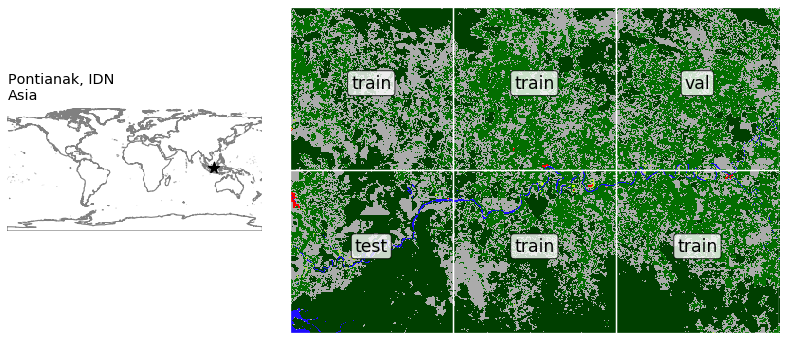

In [19]:
import matplotlib.gridspec as gridspec

raster_vrt = rasterio.open(os.path.join(verdir,'{}.vrt'.format(tyear)))

aoi_img = mpimg.imread(os.path.join(r'E:\acocac\research\AMZ\img\c5\transferlearning','map_aoi_' + tiles[0] + '.png'))

colors_split = ['#1f78b4', "#a6cee3", "#b2df8a"] 
cmap_split = ListedColormap(colors_split)

colors = dataset_config[datasets[0]]['colors']
labels = dataset_config[datasets[0]]['classes']
shorts = dataset_config[datasets[0]]['shortname']
name_dataset = dataset_config[datasets[0]]['name']

n_labels = len(colors)-1
colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(n_labels),colors)
#load files
        
# fig = plt.figure(tight_layout=True)
fig = plt.figure(figsize=(14, 6), constrained_layout=False)

gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios = [0.5, 1])

for i in range(2):
    ax = fig.add_subplot(gs[0, i])
    if i == 0:
        ax.text(0,-10, tiles_name[0], size='x-large', ha="left")
        ax.imshow(aoi_img)
    else:
#         tile_shp.plot(column='split', ax=ax,  alpha=0.2,categorical=True, legend=False, cmap=cmap_split, edgecolor='black', linewidth=0.2)
        tile_shp.plot(edgecolor='white', linestyle='-',linewidth=1.3, facecolor='None', ax=ax, zorder=3)
        tile_shp.apply(lambda x: ax.annotate(x.split, xy=x.geometry.centroid.coords[0], ha='center', alpha=1, size='xx-large', bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)),axis=1);
        rasterio.plot.show(raster_vrt, cmap=colormap, interpolation='none', vmin=0, vmax=len(colors)-1, ax=ax)
#         ax01.imshow(data, cmap=colormap, interpolation='none', vmin=0, vmax=len(colors)-1) 

    ax.set_axis_off()


# fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.show()

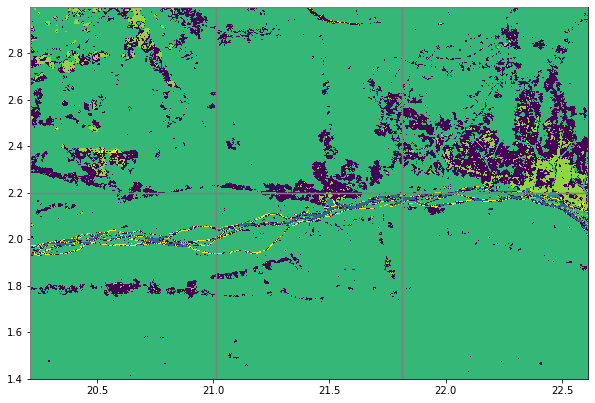

In [166]:
raster_vrt = rasterio.open(os.path.join(verdir,'{}.vrt'.format(tyear)))

fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# fold.plot(column='split', ax=ax,  categorical=True, legend=False, cmap=cmap, edgecolor='black', linewidth=0.2)
tile_shp.plot(edgecolor='gray', linewidth=1.3, facecolor='None', ax=ax, zorder=3)
rasterio.plot.show(raster_vrt)
# ax.get_legend().set_title("Partition")  #set the legend title
# leg = ax.get_legend()
# leg.get_texts()[0].set_text('Train')
# leg.get_texts()[1].set_text('Validation')
ax.set_axis_off()
raster_vrt.close()